In [1]:
import numpy as np
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import preprocessing_modules as pm

In [2]:
enc=pm.ENCODE_data(cell_line='GM12878', assembly='hg19', res=100000 ,histones=False, total_rna=True, tf=False)

Selected cell line to predict: GM12878
Selected assembly: hg19
Selected signal type: signal p-value
Selected resolution:  100 kb


In [3]:
df_x,labels=enc.get_training_data(n_neighbor=2)

Loading data from: ENCODE_data/GM12878_hg19_100k
There are 1 tracks: ['RNA']
Number of chromosomes:22

Normalizing data...
done!


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x.to_numpy(), labels, test_size=0.25, random_state=1223)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(19669, 5) (19669,) (6557, 5) (6557,)


In [5]:
learning_rate = 0.002
dropout_rate = 0.2
num_epochs = 30
batch_size = 64
num_features=df_x.shape[1]
num_classes=2

In [6]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

def create_baseline_model(num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    
    x = create_ffn([32,32], dropout_rate, name=f"ffn_block1")(inputs)
    # x = create_ffn([64], dropout_rate, name=f"ffn_block2")(x)
    for block_ndx in range(2):
        x1 = create_ffn([32,32], dropout_rate, name=f"ffn_block{block_ndx+3}")(x)
        x = layers.Add(name=f"skip_connection{block_ndx+1}")([x, x1])

    x = create_ffn([16], dropout_rate, name=f"ffn_block{block_ndx+4}")(x)
    
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


In [7]:
baseline_model = create_baseline_model(num_classes, dropout_rate)

baseline_model.summary()

2022-11-02 16:16:39.993207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 16:16:39.993362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 5)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1396        ['input_features[0][0]']         
                                                                                                  
 ffn_block3 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection1 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
         

In [8]:
history = run_experiment(baseline_model, X_train, Y_train)

Epoch 1/30


2022-11-02 16:17:04.172339: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-02 16:17:04.865395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.8061

2022-11-02 16:17:12.695134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - 9s 29ms/step - loss: 0.4271 - accuracy: 0.8061 - val_loss: 0.4638 - val_accuracy: 0.7940
Epoch 2/30
262/262 [==============================] - 7s 25ms/step - loss: 0.3800 - accuracy: 0.8326 - val_loss: 0.3891 - val_accuracy: 0.8367
Epoch 3/30
262/262 [==============================] - 7s 25ms/step - loss: 0.3705 - accuracy: 0.8362 - val_loss: 0.3586 - val_accuracy: 0.8489
Epoch 4/30
262/262 [==============================] - 6s 24ms/step - loss: 0.3625 - accuracy: 0.8416 - val_loss: 0.3542 - val_accuracy: 0.8516
Epoch 5/30
262/262 [==============================] - 6s 24ms/step - loss: 0.3612 - accuracy: 0.8417 - val_loss: 0.3498 - val_accuracy: 0.8478
Epoch 6/30
262/262 [==============================] - 6s 24ms/step - loss: 0.3586 - accuracy: 0.8420 - val_loss: 0.3513 - val_accuracy: 0.8533
Epoch 7/30
262/262 [==============================] - 7s 25ms/step - loss: 0.3592 - accuracy: 0.8442 - val_loss: 0.3524 - val_accuracy: 0.8475
Epoch 8/30

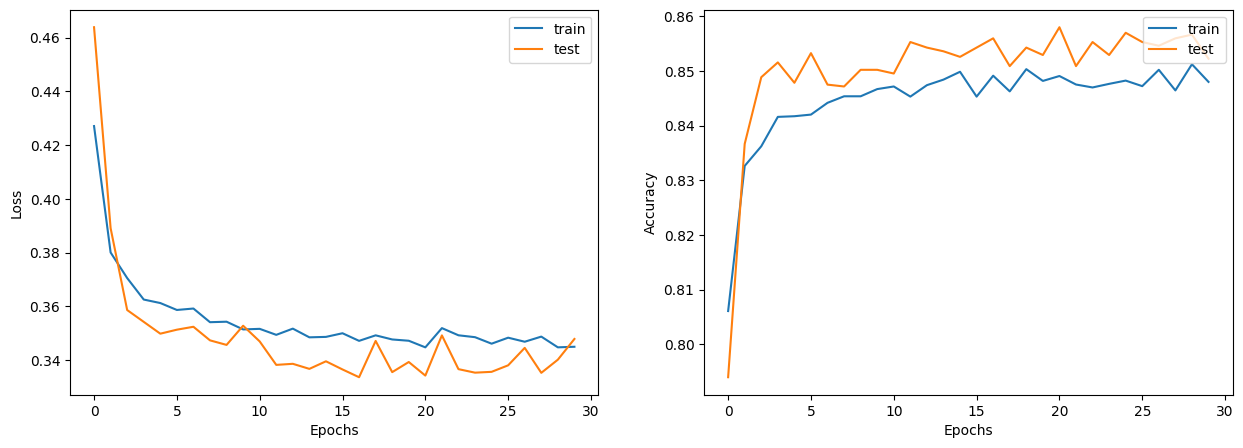

In [9]:
display_learning_curves(history)

In [17]:
for layer in baseline_model.layers:
    print(layer.name)

    if hasattr(layer, "layers"):
        for sub_layer in layer.layers:
            print('sub', sub_layer.name)
    else:
        weights=layer.get_weights()
        print(weights)

    print('\n')

input_features
[]


ffn_block1
sub batch_normalization
sub dropout
sub dense
sub batch_normalization_1
sub dropout_1
sub dense_1


ffn_block3
sub batch_normalization_2
sub dropout_2
sub dense_2
sub batch_normalization_3
sub dropout_3
sub dense_3


skip_connection1
[]


ffn_block4
sub batch_normalization_4
sub dropout_4
sub dense_4
sub batch_normalization_5
sub dropout_5
sub dense_5


skip_connection2
[]


ffn_block5
sub batch_normalization_6
sub dropout_6
sub dense_6


logits
[array([[ 0.00593041, -0.19112371],
       [-0.34644532,  0.04291009],
       [-0.13894072,  0.17283773],
       [ 0.31908426,  0.19140893],
       [-0.15165512, -0.16510542],
       [-0.13357161, -0.46471375],
       [ 0.05216409, -0.2090729 ],
       [-0.48932514, -0.17850216],
       [-0.19384581,  0.08505918],
       [-0.3190605 , -0.2779459 ],
       [-0.02250399, -0.11890879],
       [ 0.00746107,  0.3551814 ],
       [-0.22932635,  0.0839152 ],
       [-0.40498263, -0.29257786],
       [-0.1858233 , -0.2170

In [21]:
weights=baseline_model.get_layer(name='ffn_block1').get_layer(name='dense').get_weights()

print(weights[0].shape, weights[1].shape)

(5, 32) (32,)


In [20]:
len(weights)

2